# **Tabular Reinforcement Learning**

# M2-3 Monte Carlo methods

## Example of the "On-Policy first-visit MC Control with $\epsilon$-greedy policy" algorithm

Below we will see a simple example that will allow us to understand the concepts introduced in this section.  

First we will install the [Gymnasium](https://gymnasium.farama.org/) library (if we do not have it installed):

> !pip install gymnasium

For backward compatibility with code created for OpenAI Gym.

## The CliffWalking environment

The CliffWalking environment consists of an agent that moves on a grid of dimensions 12x4 (width x height). 
- In each step, the agent has 4 options for action or movement: UP, DOWN, RIGHT, LEFT. 
- The agent always starts from the same square [0, 3] (lower left corner) and the game ends when the agent reaches the arrival square [11, 3] (lower right corner). 
- The position of each box is given by a pair of natural numbers [x, y], where the position of the top left corner would be the origin of coordinates [0, 0].
- Immediate reward is R=-1 for all the boxes, except in the boxes that connect the departure box to the arrival box in a straight line (boxes [1, 3] to [10, 3]). In these boxes, which simulate a **cliff**, the reward is R=-100 and you return to the initial box.

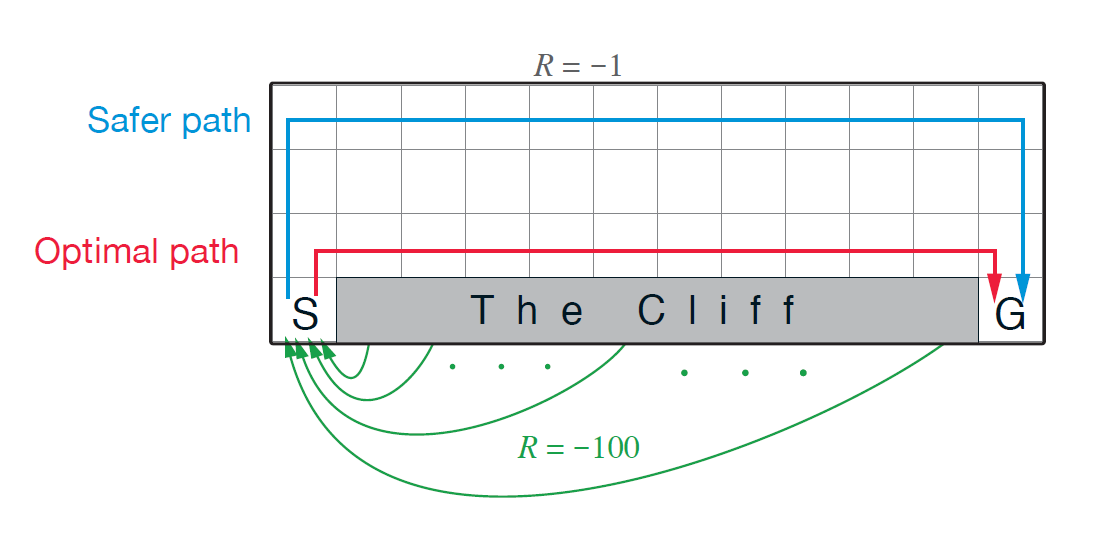

The code to implement this environment, which is available in the attached file `cliff_env.py`, has been adapted from the following link: 
- https://pypi.org/project/gym-gridworlds/

### 1. Data load

The following code loads the packages necessary to run the example, creates the environment by instantiating an object of the `CliffEnv` class, and prints the dimension of the action space:
- 0 = up, 
- 1 = right, 
- 2 = down,
- and 3 = left

The space of observations is a **tuple** indicating the **position of the agent** in the grid, and the **range of the reward** variable (whose value is -1 or -100 depending on the cell visited and which therefore goes from less infinity to more infinity).

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

switch_action = {
        0: "U",
        1: "R",
        2: "D",
        3: "L",
    }

class CliffEnv(gym.Env):
    def __init__(self, width=12, height=4):
        self.width = width
        self.height = height
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((
                spaces.Discrete(self.width),
                spaces.Discrete(self.height)
                ))
        self.moves = {
                0: (0, -1),   # up
                1: (1, 0),   # right
                2: (0, 1),  # down
                3: (-1, 0),  # left
                }
        self.timesteps = 0
        self.max_timesteps = 100
        self.reward_range = (-100, 1000)
        # begin in start state
        self.reset()

    def step(self, action):
        self.timesteps += 1
        x, y = self.moves[action]
        self.S = self.S[0] + x, self.S[1] + y

        self.S = max(0, self.S[0]), max(0, self.S[1])
        self.S = (min(self.S[0], self.width-1), min(self.S[1], self.height-1))

        # truncation
        if self.timesteps >= self.max_timesteps:
            # truncated
            return self.S, -1, True, {}
        
        # other
        if self.S == (self.width - 1, self.height - 1):
            # get Goal state
            return self.S, 1000, True, {}
        elif self.S[0] != 0 and self.S[1] == self.height - 1:
            # the cliff
            self.init_S()
            return self.S, -100, False, {}
        else:
            # anything else
            return self.S, -1, False, {}
        
    def init_S(self):
        self.S = (0, self.height-1)

    def reset(self):
        self.init_S()
        self.timesteps = 0
        return self.S

In [2]:
env = CliffEnv()

print("Action space is     : {} ".format(env.action_space))
print("Observation space is: {} ".format(env.observation_space))
print("Reward range is     : {} ".format(env.unwrapped.reward_range))

Action space is     : Discrete(4) 
Observation space is: Tuple(Discrete(12), Discrete(4)) 
Reward range is     : (-100, 1000) 


### 2. Running a random episode

Next, we will execute an episode of the _CliffWalking environment_ using an agent that selects actions randomly.

In [3]:
# Environment reset
obs = env.reset()
t, total_reward, done = 0, 0, False

print("Obs inicial: {} ".format(obs))

while not done:
    # Elegir una acción aleatoria (ésta es la implementación del agente)
    action = env.action_space.sample()
    
    # Ejecutar la acción y esperar la respuesta del entorno
    new_obs, reward, done, info = env.step(action)
    
    # Actualizar variables
    obs = new_obs
    total_reward += reward
    t += 1
    
print("Episode finished after {} timesteps and reward was {} ".format(t, total_reward))
env.close()

Obs inicial: (0, 3) 
Episode finished after 100 timesteps and reward was -1189 


### 3. Monte Carlo methods

In this section we will see an estimation of the **optimal policy** using **Monte Carlo methods**, specifically we will study the **_On-policy first-visit MC control algorithm (for $\epsilon$-soft policies)_**.

We will use the following parameters:
- Number of episodes = 500,000
- Epsilon = 0.8
- Discount factor = 1

Note that we use an $\epsilon$-greedy policy **without** decay factor.

In [4]:
## Adapted from:
## https://github.com/dennybritz/reinforcement-learning/tree/master/MC
import numpy as np
from collections import defaultdict
import sys
import time


def make_epsilon_greedy_policy(Q, epsilon, num_Actions):
    """
    Creates an epsilon-greedy policy based on a Q and epsilon action value function
    
    Args:
         Q: A dictionary whose correspondence is state -> action-values.
            Each value is a numpy array of length num_Actions (see below)
         epsilon: The probability of selecting a random action (float between 0 and 1).
         num_Actions: Number of actions in the environment. (in the case of WIndyGridWorld it is 4)
    
    Returns:
         A function that takes the observation as an argument and returns as a result
         the probabilities of each action as a numpy array of length num_Actions.
    """
    def policy_fn(observation):
        A = np.ones(num_Actions, dtype=float) * epsilon / num_Actions
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)

        return A
    
    return policy_fn

def mc_control_on_policy_epsilon_greedy(env, num_episodes, discount=1.0, epsilon=0.1):
    """
    Control by Monte Carlo methods using Epsilon-Greedy policies
    Find an epsilon-greedy policy.
    
    Args:
         env: Gymnasium environment.
         num_episodes: Number of episodes in the sample.
         discount: discount factor.
         epsilon: The probability of selecting a random action (float between 0 and 1)
    
    Returns:
         A tuple (Q, policy).
         Q: A dictionary whose correspondence is state -> action-values.
         policy: A function that takes the observation as an argument and returns as a result
                 the probabilities of each action
    """
    
    # We store the sum and number of returns for each state to calculate the average. 
    # We could use an array to store all the returns, but it is inefficient in terms of memory.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The Q action value function.
    # A nested dictionary whose correspondence is state -> (action -> action-value).
    # Initially we initialize it to zero
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_episode in range(1, num_episodes + 1):
        # The policy we are following
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
        
        # We print which episode we are in, useful for debugging.
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # We generate an episode and store it
        # An episode is an array of tuples (state, action, reward)
        episode = []
        state = env.reset()
        done = False
        while not done:
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        idx = 0
        
        # Find all the (state, action) pairs we have visited in this episode
        # Convert each state into a tuple so we can use it as a dictionary key
        sar_in_episode = set([(tuple(x[0]), x[1], x[2]) for x in episode])

        # for each time step
        for state, action, reward in sar_in_episode:
            sa_pair = (state, action)

            # We find the first appearance of the pair (state, action) in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
            
            # We add up all the rewards since the first appearance
            G = sum([x[2]*(discount**i) for i,x in enumerate(episode[first_occurence_idx:])])
            
            # We calculate the average return for this state over all sampled episodes
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
        # The policy is implicitly improved by changing the values of Q
    
    return Q, policy

In [5]:
# Execute
Q, policy = mc_control_on_policy_epsilon_greedy(env, num_episodes=500000, discount=1, epsilon=0.8)

Episode 500000/500000

Implement a function that prints on the screen the **optimal policy** found for each cell.

In [6]:
def print_policy_MC(policy, width, height):
    switch_action = {
        0: "U",
        1: "R",
        2: "D",
        3: "L"
    }
    for j in range(height):
        print("------------------------------------------------------------------------")
        for i in range(width):
            arr = np.array(policy((i,j)))
            act = int(np.where(arr == np.amax(arr))[0])
            a = switch_action[act]
            print("  %s  |" % a, end="")
        print("")
        
    print("------------------------------------------------------------------------")

In [7]:
print_policy_MC(policy, 12, 4)

------------------------------------------------------------------------
  R  |  R  |  R  |  R  |  R  |  R  |  R  |  R  |  R  |  R  |  R  |  D  |
------------------------------------------------------------------------
  U  |  U  |  U  |  U  |  U  |  U  |  R  |  R  |  R  |  R  |  R  |  D  |
------------------------------------------------------------------------
  U  |  U  |  U  |  U  |  U  |  U  |  U  |  U  |  U  |  R  |  R  |  D  |
------------------------------------------------------------------------
  U  |  U  |  U  |  U  |  U  |  U  |  U  |  U  |  U  |  U  |  U  |  U  |
------------------------------------------------------------------------


C:\Users\victo\AppData\Local\Temp\ipykernel_24444\2225160804.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  act = int(np.where(arr == np.amax(arr))[0])


Run an episode with the optimal policy found and show the **agent's trajectory** and the **return** obtained.

In [8]:
def execute_episode_MC(policy, env):
    obs = env.reset()
    t, total_reward, done = 0, 0, False
    print("Obs inicial: {} ".format(obs))

    switch_action = {
            0: "U",
            1: "R",
            2: "D",
            3: "L",
        }

    for t in range(1000): # We limit the number of time-steps in each episode to 1000
        # We choose the optimal policy in each case (the maximum of the Epsilon-Greedy policy)
        arr = np.array(policy(obs))
        action = arr.argmax()
    
        # We execute the action and wait for the response from the environment
        new_obs, reward, done, info = env.step(action)
        print("{} - {} --> {} and reward: {}".format(obs, switch_action[action], new_obs, reward))
        obs = new_obs

        if t==999:
            print("Number of time-septs exceeds 1000. STOP episode.")
            
        total_reward += reward
        t += 1
        if done:
            break
        
    print("Episode finished after {} timesteps and reward was {} ".format(t, total_reward))
    env.close()

In [9]:
execute_episode_MC(policy, env)

Obs inicial: (0, 3) 
(0, 3) - U --> (0, 2) and reward: -1
(0, 2) - U --> (0, 1) and reward: -1
(0, 1) - U --> (0, 0) and reward: -1
(0, 0) - R --> (1, 0) and reward: -1
(1, 0) - R --> (2, 0) and reward: -1
(2, 0) - R --> (3, 0) and reward: -1
(3, 0) - R --> (4, 0) and reward: -1
(4, 0) - R --> (5, 0) and reward: -1
(5, 0) - R --> (6, 0) and reward: -1
(6, 0) - R --> (7, 0) and reward: -1
(7, 0) - R --> (8, 0) and reward: -1
(8, 0) - R --> (9, 0) and reward: -1
(9, 0) - R --> (10, 0) and reward: -1
(10, 0) - R --> (11, 0) and reward: -1
(11, 0) - D --> (11, 1) and reward: -1
(11, 1) - D --> (11, 2) and reward: -1
(11, 2) - D --> (11, 3) and reward: 1000
Episode finished after 17 timesteps and reward was 984 
